# Applying the ResNet-50 to scaleograms as in Daydulo et al. 2022

[Daydulo et al. 2022](https://doi.org/10.1186/s12911-022-02068-1) - Deep learning based fetal distress detection from time frequency representation of cardiotocogram signal using Morse wavelet: research study.

Open Access This article is licensed under a Creative Commons Attribution 4.0 International License, which permits use, sharing, adaptation, distribution and reproduction in any medium or format, as long as you give appropriate credit to the original author(s) and the source, provide a link to the Creative Commons licence, and indicate if changes were made. The images or other third party material in this article are included in the article's Creative Commons licence, unless indicated otherwise in a credit line to the material. If material is not included in the article's Creative Commons licence and your intended use is not permitted by statutory regulation or exceeds the permitted use, you will need to obtain permission directly from the copyright holder. To view a copy of this licence, visit http://creativecommons.org/licenses/by/4.0/. The Creative Commons Public Domain Dedication waiver (http://creativecommons.org/publicdomain/zero/1.0/) applies to the data made available in this article, unless otherwise stated in a credit line to the data. Reprints and Permissions

## About ResNet-50

ResNet-50 is a 50 layer Residual network. It is a pre-trained convolutional neural network for image classification and computer vision. The 50 layers include 48 convolution layers, 1 average pool layer, and 1 max pooling layer.

Implementation of ResNet-50 in this notebook was based on the following article: https://medium.com/@bravinwasike18/building-a-deep-learning-model-with-keras-and-resnet-50-9dd6f4eb3351

## Set up

In [1]:
# TensorFlow will run in the backend of the classification model, and we import
# Keras from TensorFlow to initialise the deep learning model, and import the
# ResNet-50 network model from Keras API.
import tensorflow as tf
from tensorflow import keras

# Optimiser
from tensorflow.keras.optimizers import Adam

# To add custom input and output layers to finetune the network
from tensorflow.keras import layers

# To display images
from PIL import Image

# To create figures
import matplotlib.pyplot as plt

2023-12-05 15:36:32.791400: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 15:36:32.868699: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 15:36:32.868753: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 15:36:32.868814: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 15:36:32.883293: I tensorflow/core/platform/cpu_feature_g

## Find width and height of the images

(496, 369)


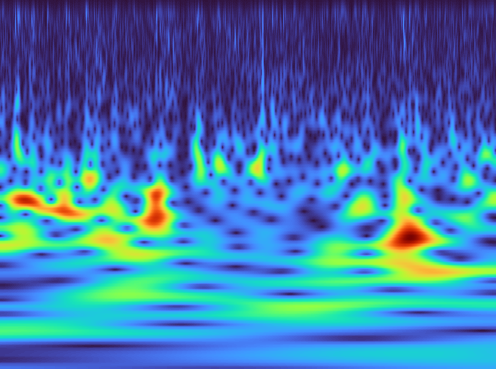

In [2]:
# Import an image
im = Image.open('outputs/daydulo_cwt_first_stage/train/class_0_normal/1003.png')

# Get width and height
width, height = im.size
print(im.size)

# Show image
im

## First stage

### Import training, validation and test sets

Daydulo et al. 2022 state that they use a mini batch size of 30. I am not certain what image sizes they used.

In [3]:
# Import the training set
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    'outputs/daydulo_cwt_first_stage/train/',
    image_size=(height,width),
    batch_size=30)

Found 629 files belonging to 2 classes.


2023-12-05 15:36:36.681081: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 15:36:36.690503: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-05 15:36:36.690812: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
# Import the validation set
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    'outputs/daydulo_cwt_first_stage/validation/',
    image_size=(height,width),
    batch_size=30)

Found 71 files belonging to 2 classes.


In [5]:
# Import the test set
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    'outputs/daydulo_cwt_first_stage/test/',
    image_size=(height, width),
    batch_size=30)

Found 78 files belonging to 2 classes.


In [6]:
# View the class names
train_set.class_names

['class_0_normal', 'class_1_distressed']

### Build the deep learning model

Initialise TensorFlow Sequential model, which will allow use to add custom input and output layers to the pre-trained ResNet-50.

In [7]:
dnn_model = keras.Sequential()

Import pre-trained ResNet-50 model.

These parameters are based on [this tutorial](https://medium.com/@bravinwasike18/building-a-deep-learning-model-with-keras-and-resnet-50-9dd6f4eb3351) - I have not yet spot if they are given anywhere in Daydulo et al. 2022.

In [8]:
imported_model= tf.keras.applications.ResNet50(
    include_top=False, # Ensures we can add custom input and output layers
    input_shape=(height, width, 3),
    pooling='avg', # Average pooling techniques
    classes=2, # The number of categories
    weights='imagenet') # Use the imagenet weights for classification

for layer in imported_model.layers:
    layer.trainable=False # Ensures the parameters and weights are not trained again to speed up training process

Fine-tune the imported ResNet-50 network by adding custom input and output layers. These layers will enable the model to understand our data and produced the desired results.

These parameters are based on [this tutorial](https://medium.com/@bravinwasike18/building-a-deep-learning-model-with-keras-and-resnet-50-9dd6f4eb3351) - I have not yet spot if they are given anywhere in Daydulo et al. 2022.

In [9]:
dnn_model.add(imported_model)
dnn_model.add(layers.Flatten())
dnn_model.add(layers.Dense(512, activation='relu')) # 512 neurons
# Since it's binary, I think using softmax is the same as using sigmoid?
dnn_model.add(layers.Dense(2, activation='softmax')) # 2 neurons (as 2 categories)

In [10]:
# View model summary
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24637826 (93.99 MB)
Trainable params: 1050114 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


Compile the model.

Daydulo et al. 2022 state that they use an Adam optimiser with learning rate 0.001.

In [11]:
dnn_model.compile(
    optimizer=Adam(learning_rate=0.001), # will improve performance and accuracy, and handle and debug errors in training
    loss='sparse_categorical_crossentropy', # how we calculate rerors during training
    metrics=['accuracy']) # how we evaluate model performance after each training cycle (epoch)

Fit the compiled model with the training and validation set.

In Daydulo et al. 2022:
* They state their validation frequency set is 15 iterations.
* They state that they use validation frequency 20 iteration.
* Their figures show that there were apx. 800 iterations.

As 800 iterations would take a very long time to run, I have tried it with 100 iterations.

In [12]:
history = dnn_model.fit(
    train_set,
    validation_data=validation_set,
    epochs=100)

Epoch 1/100


2023-12-05 15:36:48.029651: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-12-05 15:36:53.002735: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa76000b810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-05 15:36:53.002765: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2023-12-05 15:36:53.011857: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-05 15:36:53.159247: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 [==============================] - 26s 739ms/step - loss: 1.3034 - accuracy: 0.5469 - val_loss: 0.8676 - val_accuracy: 0.4648
Epoch 2/100
21/21 [==============================] - 9s 437ms/step - loss: 0.7067 - accuracy: 0.5692 - val_loss: 0.6098 - val_accuracy: 0.6761
Epoch 3/100
21/21 [==============================] - 10s 445ms/step - loss: 0.6465 - accuracy: 0.6502 - val_loss: 0.6815 - val_accuracy: 0.5915
Epoch 4/100
21/21 [==============================] - 10s 444ms/step - loss: 0.6516 - accuracy: 0.6200 - val_loss: 0.8640 - val_accuracy: 0.5211
Epoch 5/100
21/21 [==============================] - 10s 444ms/step - loss: 0.7179 - accuracy: 0.5962 - val_loss: 1.0582 - val_accuracy: 0.4930
Epoch 6/100
21/21 [==============================] - 9s 442ms/step - loss: 0.7217 - accuracy: 0.5978 - val_loss: 0.6788 - val_accuracy: 0.5634
Epoch 7/100
21/21 [==============================] - 9s 443ms/step - loss: 0.6252 - accuracy: 0.6343 - val_loss: 0.6711 - val_accuracy: 0.5634
Epoch 8

Plot the training and validation curves

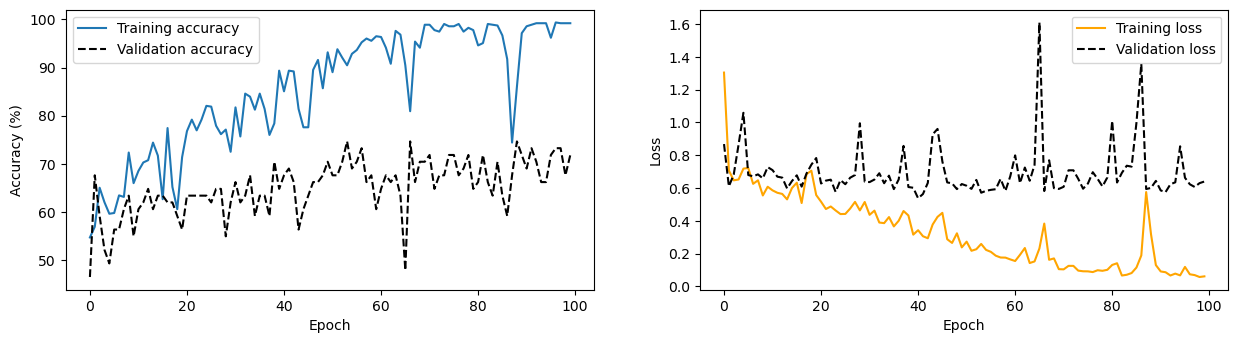

In [13]:
plt.figure(figsize = (15, 8))

# Plot the training and validation accuracy as a percentage
plt.subplot(221)
plt.plot([i*100 for i in history.history['accuracy']])
plt.plot([i*100 for i in history.history['val_accuracy']],
         linestyle='--', color='black')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(['Training accuracy', 'Validation accuracy'])

# Plot the training and validation loss
plt.subplot(222)
plt.plot(history.history['loss'], color='orange')
plt.plot(history.history['val_loss'], linestyle='--', color='black')
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['Training loss', 'Validation loss']) 

plt.show()

Comparisons to the paper:
* Reachs training accuracy much quicker (as only did 100 epochs), but that diverges from validation accuracy.
* Not certain that ResNet-50 parameters are definietely all the same as can only go in information found in their paper, do not have their code
* There were slight differences in my images due to the scale range determined by ssqueezepy

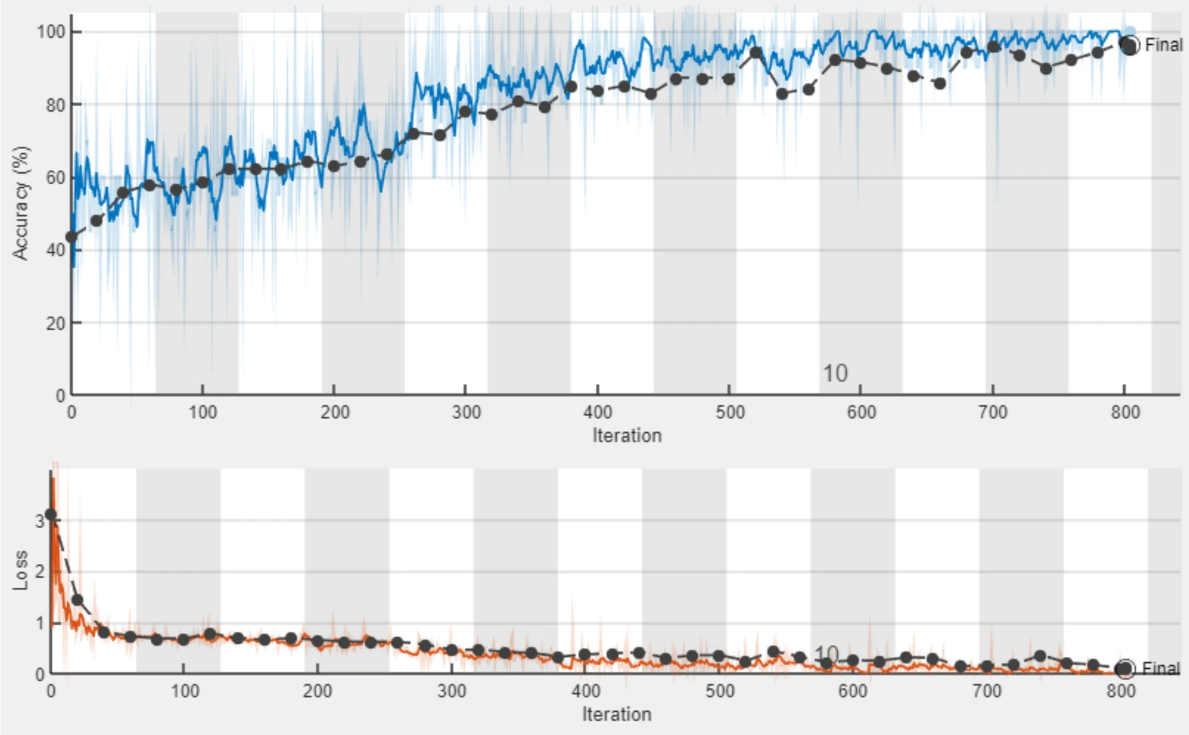

In [15]:
Image.open('images/daydulo_figure9a.png')